In [1]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import label_binarize

from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_curve, roc_auc_score, classification_report

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import ExtraTreesClassifier
from lightgbm import LGBMClassifier

from concurrent.futures import ThreadPoolExecutor

from imblearn.under_sampling import RandomUnderSampler

from yellowbrick.classifier import ConfusionMatrix
import seaborn as sns
from sklearn.metrics import confusion_matrix

import warnings

In [2]:
def convert_to_integer(value): # Birden fazla dbm_antsignal değerlerinin olduğu durumda dönüşüm işlemi için 
    if pd.isna(value) or value == '':
        return None 
    elif isinstance(value, int) or isinstance(value, float):
        return value
    else:
        signal_strengths = [int(v) for v in value.split('-') if v]
        if signal_strengths:
            average_strength = round(sum(signal_strengths) / len(signal_strengths))
            return -average_strength
        else:
            return None

In [3]:
warnings.filterwarnings('ignore')

In [4]:
features = ['frame.interface_id',
 'frame.dlt',
 'frame.offset_shift',
 'frame.time_epoch',
 'frame.time_delta',
 'frame.time_delta_displayed',
 'frame.time_relative',
 'frame.len',
 'frame.cap_len',
 'frame.marked',
 'frame.ignored',
 'radiotap.version',
 'radiotap.pad',
 'radiotap.length',
 'radiotap.present.tsft',
 'radiotap.present.flags',
 'radiotap.present.rate',
 'radiotap.present.channel',
 'radiotap.present.fhss',
 'radiotap.present.dbm_antsignal',
 'radiotap.present.dbm_antnoise',
 'radiotap.present.lock_quality',
 'radiotap.present.tx_attenuation',
 'radiotap.present.db_tx_attenuation',
 'radiotap.present.dbm_tx_power',
 'radiotap.present.antenna',
 'radiotap.present.db_antsignal',
 'radiotap.present.db_antnoise',
 'radiotap.present.rxflags',
 'radiotap.present.xchannel',
 'radiotap.present.mcs',
 'radiotap.present.ampdu',
 'radiotap.present.vht',
 'radiotap.present.reserved',
 'radiotap.present.rtap_ns',
 'radiotap.present.vendor_ns',
 'radiotap.present.ext',
 'radiotap.mactime',
 'radiotap.flags.cfp',
 'radiotap.flags.preamble',
 'radiotap.flags.wep',
 'radiotap.flags.frag',
 'radiotap.flags.fcs',
 'radiotap.flags.datapad',
 'radiotap.flags.badfcs',
 'radiotap.flags.shortgi',
 'radiotap.datarate',
 'radiotap.channel.freq',
 'radiotap.channel.type.turbo',
 'radiotap.channel.type.cck',
 'radiotap.channel.type.ofdm',
 'radiotap.channel.type.2ghz',
 'radiotap.channel.type.5ghz',
 'radiotap.channel.type.passive',
 'radiotap.channel.type.dynamic',
 'radiotap.channel.type.gfsk',
 'radiotap.channel.type.gsm',
 'radiotap.channel.type.sturbo',
 'radiotap.channel.type.half',
 'radiotap.channel.type.quarter',
 'radiotap.dbm_antsignal',
 'radiotap.antenna',
 'radiotap.rxflags.badplcp',
 'wlan.fc.type_subtype',
 'wlan.fc.version',
 'wlan.fc.type',
 'wlan.fc.subtype',
 'wlan.fc.ds',
 'wlan.fc.frag',
 'wlan.fc.retry',
 'wlan.fc.pwrmgt',
 'wlan.fc.moredata',
 'wlan.fc.protected',
 'wlan.fc.order',
 'wlan.duration',
 'wlan.ra',
 'wlan.da',
 'wlan.ta',
 'wlan.sa',
 'wlan.bssid',
 'wlan.frag',
 'wlan.seq',
 'wlan.bar.type',
 'wlan.ba.control.ackpolicy',
 'wlan.ba.control.multitid',
 'wlan.ba.control.cbitmap',
 'wlan.bar.compressed.tidinfo',
 'wlan.ba.bm',
 'wlan.fcs_good',
 'wlan_mgt.fixed.capabilities.ess',
 'wlan_mgt.fixed.capabilities.ibss',
 'wlan_mgt.fixed.capabilities.cfpoll.ap',
 'wlan_mgt.fixed.capabilities.privacy',
 'wlan_mgt.fixed.capabilities.preamble',
 'wlan_mgt.fixed.capabilities.pbcc',
 'wlan_mgt.fixed.capabilities.agility',
 'wlan_mgt.fixed.capabilities.spec_man',
 'wlan_mgt.fixed.capabilities.short_slot_time',
 'wlan_mgt.fixed.capabilities.apsd',
 'wlan_mgt.fixed.capabilities.radio_measurement',
 'wlan_mgt.fixed.capabilities.dsss_ofdm',
 'wlan_mgt.fixed.capabilities.del_blk_ack',
 'wlan_mgt.fixed.capabilities.imm_blk_ack',
 'wlan_mgt.fixed.listen_ival',
 'wlan_mgt.fixed.current_ap',
 'wlan_mgt.fixed.status_code',
 'wlan_mgt.fixed.timestamp',
 'wlan_mgt.fixed.beacon',
 'wlan_mgt.fixed.aid',
 'wlan_mgt.fixed.reason_code',
 'wlan_mgt.fixed.auth.alg',
 'wlan_mgt.fixed.auth_seq',
 'wlan_mgt.fixed.category_code',
 'wlan_mgt.fixed.htact',
 'wlan_mgt.fixed.chanwidth',
 'wlan_mgt.fixed.fragment',
 'wlan_mgt.fixed.sequence',
 'wlan_mgt.tagged.all',
 'wlan_mgt.ssid',
 'wlan_mgt.ds.current_channel',
 'wlan_mgt.tim.dtim_count',
 'wlan_mgt.tim.dtim_period',
 'wlan_mgt.tim.bmapctl.multicast',
 'wlan_mgt.tim.bmapctl.offset',
 'wlan_mgt.country_info.environment',
 'wlan_mgt.rsn.version',
 'wlan_mgt.rsn.gcs.type',
 'wlan_mgt.rsn.pcs.count',
 'wlan_mgt.rsn.akms.count',
 'wlan_mgt.rsn.akms.type',
 'wlan_mgt.rsn.capabilities.preauth',
 'wlan_mgt.rsn.capabilities.no_pairwise',
 'wlan_mgt.rsn.capabilities.ptksa_replay_counter',
 'wlan_mgt.rsn.capabilities.gtksa_replay_counter',
 'wlan_mgt.rsn.capabilities.mfpr',
 'wlan_mgt.rsn.capabilities.mfpc',
 'wlan_mgt.rsn.capabilities.peerkey',
 'wlan_mgt.tcprep.trsmt_pow',
 'wlan_mgt.tcprep.link_mrg',
 'wlan.wep.iv',
 'wlan.wep.key',
 'wlan.wep.icv',
 'wlan.tkip.extiv',
 'wlan.ccmp.extiv',
 'wlan.qos.tid',
 'wlan.qos.priority',
 'wlan.qos.eosp',
 'wlan.qos.ack',
 'wlan.qos.amsdupresent',
 'wlan.qos.buf_state_indicated1',
 'wlan.qos.bit4',
 'wlan.qos.txop_dur_req',
 'wlan.qos.buf_state_indicated2',
 'data.len',
 'class']

selected_features = ['frame.len', 'radiotap.length', 'radiotap.dbm_antsignal', 'radiotap.channel.freq', 'wlan.duration', 'radiotap.present.tsft', 'radiotap.channel.type.cck', 'radiotap.channel.type.ofdm', 'wlan.fc.type', 'wlan.fc.subtype', 'wlan.fc.ds', 'wlan.fc.frag', 'wlan.fc.retry', 'wlan.fc.pwrmgt', 'wlan.fc.moredata', 'wlan.fc.protected']

### Read AWID2 Trn

In [5]:
awid2trn_data = pd.read_csv("./AWID-CLS-R-Trn/AWID-CLS-R-Trn/1", header=None, names=features, low_memory=False)

awid2trn_data = awid2trn_data.loc[:, selected_features + ['class']]
pd.set_option('display.max_columns', None)

awid2trn_data.head(10)

,frame.len,radiotap.length,radiotap.dbm_antsignal,radiotap.channel.freq,wlan.duration,radiotap.present.tsft,radiotap.channel.type.cck,radiotap.channel.type.ofdm,wlan.fc.type,wlan.fc.subtype,wlan.fc.ds,wlan.fc.frag,wlan.fc.retry,wlan.fc.pwrmgt,wlan.fc.moredata,wlan.fc.protected,class
0,261,26,-47,2437,0,1,1,0,0,8,0x00,0,0,0,0,0,normal
1,185,26,-47,2437,0,1,1,0,0,8,0x00,0,0,0,0,0,normal
2,185,26,-64,2437,0,1,1,0,0,8,0x00,0,0,0,0,0,normal
3,159,26,-32,2437,0,1,1,0,0,8,0x00,0,0,0,0,0,normal
4,54,26,-21,2437,44,1,0,1,2,4,0x01,0,0,0,0,0,normal
5,40,26,-24,2437,0,1,0,1,1,13,0x00,0,0,0,0,0,normal
6,261,26,-47,2437,0,1,1,0,0,8,0x00,0,0,0,0,0,normal
7,40,26,-24,2437,0,1,0,1,1,13,0x00,0,0,0,0,0,normal
8,185,26,-52,2437,0,1,1,0,0,8,0x00,0,0,0,0,0,normal
9,185,26,-58,2437,0,1,1,0,0,8,0x00,0,0,0,0,0,normal


### Read AWID2 Tst

In [6]:
awid2tst_data = pd.read_csv("./AWID-CLS-R-Tst/AWID-CLS-R-Tst/awid2test", header=None, names=features, low_memory=False)

awid2tst_data = awid2tst_data.loc[:, selected_features + ['class']]
pd.set_option('display.max_columns', None)

awid2tst_data.head(10)

,frame.len,radiotap.length,radiotap.dbm_antsignal,radiotap.channel.freq,wlan.duration,radiotap.present.tsft,radiotap.channel.type.cck,radiotap.channel.type.ofdm,wlan.fc.type,wlan.fc.subtype,wlan.fc.ds,wlan.fc.frag,wlan.fc.retry,wlan.fc.pwrmgt,wlan.fc.moredata,wlan.fc.protected,class
0,1552,26,-25,2437,44,1,0,1,2,8,0x02,0,0,0,0,1,normal
1,1552,26,-25,2437,44,1,0,1,2,8,0x02,0,1,0,0,1,normal
2,40,26,-26,2437,0,1,0,1,1,13,0x00,0,0,0,0,0,normal
3,40,26,-26,2437,0,1,0,1,1,13,0x00,0,0,0,0,0,normal
4,1552,26,-26,2437,44,1,0,1,2,8,0x02,0,0,0,0,1,normal
5,1552,26,-25,2437,44,1,0,1,2,8,0x02,0,0,0,0,1,normal
6,1552,26,-25,2437,44,1,0,1,2,8,0x02,0,0,0,0,1,normal
7,1552,26,-26,2437,44,1,0,1,2,8,0x02,0,0,0,0,1,normal
8,40,26,-24,2437,0,1,0,1,1,13,0x00,0,0,0,0,0,normal
9,1552,26,-26,2437,44,1,0,1,2,8,0x02,0,0,0,0,1,normal


### Dropping NaN values

In [7]:
awid2trn_data = awid2trn_data.replace(r'^\s*$', pd.NA, regex=True)
awid2trn_data = awid2trn_data.replace('?', pd.NA)
awid2trn_data = awid2trn_data.dropna()

In [8]:
awid2tst_data = awid2tst_data.replace(r'^\s*$', pd.NA, regex=True)
awid2tst_data = awid2tst_data.replace('?', pd.NA)
awid2tst_data = awid2tst_data.dropna()

### Injection rows removed

In [9]:
filter_train = awid2trn_data['class'] != 'injection'
filter_test = awid2tst_data['class'] != 'injection'
awid2trn_data = awid2trn_data[filter_train]
awid2tst_data = awid2tst_data[filter_test]

In [12]:
X_awid2trn = awid2trn_data.loc[:, selected_features]
y_awid2trn = awid2trn_data[['class']]

In [10]:
X_awid2tst = awid2tst_data.loc[:, selected_features]
y_awid2tst = awid2tst_data[['class']]

In [13]:
X_awid2trn

,frame.len,radiotap.length,radiotap.dbm_antsignal,radiotap.channel.freq,wlan.duration,radiotap.present.tsft,radiotap.channel.type.cck,radiotap.channel.type.ofdm,wlan.fc.type,wlan.fc.subtype,wlan.fc.ds,wlan.fc.frag,wlan.fc.retry,wlan.fc.pwrmgt,wlan.fc.moredata,wlan.fc.protected
0,261,26,-47,2437,0,1,1,0,0,8,0x00,0,0,0,0,0
1,185,26,-47,2437,0,1,1,0,0,8,0x00,0,0,0,0,0
2,185,26,-64,2437,0,1,1,0,0,8,0x00,0,0,0,0,0
3,159,26,-32,2437,0,1,1,0,0,8,0x00,0,0,0,0,0
4,54,26,-21,2437,44,1,0,1,2,4,0x01,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1795570,40,26,-25,2437,0,1,0,1,1,13,0x00,0,0,0,0,0
1795571,148,26,-58,2437,0,1,1,0,0,8,0x00,0,0,0,0,0
1795572,54,26,-27,2437,44,1,0,1,2,4,0x01,0,0,0,0,0
1795573,40,26,-25,2437,0,1,0,1,1,13,0x00,0,0,0,0,0


### Undersampling

In [14]:
print(f"normal:\n{y_awid2trn[y_awid2trn['class']=='normal'].count()}")
print(f"impersonation:\n{y_awid2trn[y_awid2trn['class']=='impersonation'].count()}")
print(f"flooding:\n{y_awid2trn[y_awid2trn['class']=='flooding'].count()}")
print(f"injection:\n{y_awid2trn[y_awid2trn['class']=='injection'].count()}")

normal:
class    1631218
dtype: int64
impersonation:
class    48522
dtype: int64
flooding:
class    48484
dtype: int64
injection:
class    0
dtype: int64


In [15]:
under_sampler = RandomUnderSampler(sampling_strategy='auto', random_state=42)
X_awid2trn, y_awid2trn = under_sampler.fit_resample(X_awid2trn, y_awid2trn)

In [16]:
print(f"normal:\n{y_awid2trn[y_awid2trn['class']=='normal'].count()}")
print(f"impersonation:\n{y_awid2trn[y_awid2trn['class']=='impersonation'].count()}")
print(f"flooding:\n{y_awid2trn[y_awid2trn['class']=='flooding'].count()}")
print(f"injection:\n{y_awid2trn[y_awid2trn['class']=='injection'].count()}")

normal:
class    48484
dtype: int64
impersonation:
class    48484
dtype: int64
flooding:
class    48484
dtype: int64
injection:
class    0
dtype: int64


In [17]:
print(f"normal:\n{y_awid2tst[y_awid2tst['class']=='normal'].count()}")
print(f"impersonation:\n{y_awid2tst[y_awid2tst['class']=='impersonation'].count()}")
print(f"flooding:\n{y_awid2tst[y_awid2tst['class']=='flooding'].count()}")
print(f"injection:\n{y_awid2tst[y_awid2tst['class']=='injection'].count()}")

normal:
class    530458
dtype: int64
impersonation:
class    20079
dtype: int64
flooding:
class    8097
dtype: int64
injection:
class    0
dtype: int64


### Some columns converted

In [16]:
X_awid2trn['radiotap.dbm_antsignal'] = X_awid2trn['radiotap.dbm_antsignal'].apply(convert_to_integer)

In [17]:
X_awid2tst['radiotap.dbm_antsignal'] = X_awid2tst['radiotap.dbm_antsignal'].apply(convert_to_integer)

### Encoding

In [18]:
columns_to_scale = ['frame.len', 'radiotap.length', 'radiotap.dbm_antsignal', 'wlan.duration']
columns_to_one_hot_encode = [col for col in X_awid2trn.columns if col not in columns_to_scale]

# Min-max scaling
scaler = MinMaxScaler()
X_awid2trn[columns_to_scale] = scaler.fit_transform(X_awid2trn[columns_to_scale])

scaler = MinMaxScaler()
X_awid2tst[columns_to_scale] = scaler.fit_transform(X_awid2tst[columns_to_scale])

# One-hot encoding
combined_data = pd.concat([X_awid2trn, X_awid2tst], axis=0) # Combine dataframes
combined_data = pd.get_dummies(combined_data, columns=columns_to_one_hot_encode)
X_awid2trn_encoded = combined_data[:len(X_awid2trn)]
X_awid2tst_encoded = combined_data[len(X_awid2trn):]

### Functions for results

In [19]:
def calculate_precision_recall_f1(y_test, y_pred):
    """ Hesaplanan metrikleri sözlük yapısında döndürmektedir. """
    metrics = {
        'precision_weighted': precision_score(y_test, y_pred, average='weighted'),
        'precision_micro': precision_score(y_test, y_pred, average='micro'),
        'precision_macro': precision_score(y_test, y_pred, average='macro'),
        'recall_weighted': recall_score(y_test, y_pred, average='weighted'),
        'recall_micro': recall_score(y_test, y_pred, average='micro'),
        'recall_macro': recall_score(y_test, y_pred, average='macro'),
        'f1_weighted': f1_score(y_test, y_pred, average='weighted'),
        'f1_micro': f1_score(y_test, y_pred, average='micro'),
        'f1_macro': f1_score(y_test, y_pred, average='macro')
    }
    return metrics

In [20]:
def calculate_auc(classifier, X_test, y_test):
    if hasattr(classifier, 'predict_proba'):
        y_pred_proba = classifier.predict_proba(X_test)
        if y_pred_proba.shape[1] == 2: # Binary classification
            return roc_auc_score(y_test, y_pred_proba[:, 1])
        else:
            return roc_auc_score(label_binarize(y_test, classes=np.unique(y_test)), y_pred_proba, multi_class='ovr')
    elif hasattr(classifier, 'decision_function'):
        y_scores = classifier.decision_function(X_test)
        if len(np.unique(y_test)) == 2:  # Binary classification
            return roc_auc_score(y_test, y_scores)
        else:  # Multi-class classification
            return roc_auc_score(label_binarize(y_test, classes=np.unique(y_test)), y_scores, multi_class='ovr')
    else:
        return None

In [21]:
def print_metrics(accuracy, metrics, auc):
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Weighted Precision: {metrics['precision_weighted']:.4f}")
    print(f"Micro Precision: {metrics['precision_micro']:.4f}")
    print(f"Macro Precision: {metrics['precision_macro']:.4f}")
    print(f"Weighted Recall: {metrics['recall_weighted']:.4f}")
    print(f"Micro Recall: {metrics['recall_micro']:.4f}")
    print(f"Macro Recall: {metrics['recall_macro']:.4f}")
    print(f"Weighted F1 Score: {metrics['f1_weighted']:.4f}")
    print(f"Micro F1 Score: {metrics['f1_micro']:.4f}")
    print(f"Macro F1 Score: {metrics['f1_macro']:.4f}")
    print(f"AUC Score: {auc:.4f}")


In [22]:
def display_confusion_matrix(classifier, X_test, y_test):
    cm = ConfusionMatrix(classifier, classes=['Flooding', 'Impersonation', 'Normal'])
    cm.score(X_test, y_test)
    cm.show()

In [23]:
def evaluate_classifier(classifier, X_test, y_test):
    y_pred = classifier.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    metrics = calculate_precision_recall_f1(y_test, y_pred)
    auc = calculate_auc(classifier, X_test, y_test)

    print_metrics(accuracy, metrics, auc)
    display_confusion_matrix(classifier, X_test, y_test)

### Decision Tree

Accuracy: 0.9282
Weighted Precision: 0.9507
Micro Precision: 0.9282
Macro Precision: 0.4299
Weighted Recall: 0.9282
Micro Recall: 0.9282
Macro Recall: 0.5743
Weighted F1 Score: 0.9375
Micro F1 Score: 0.9282
Macro F1 Score: 0.4619
AUC Score: 0.7229


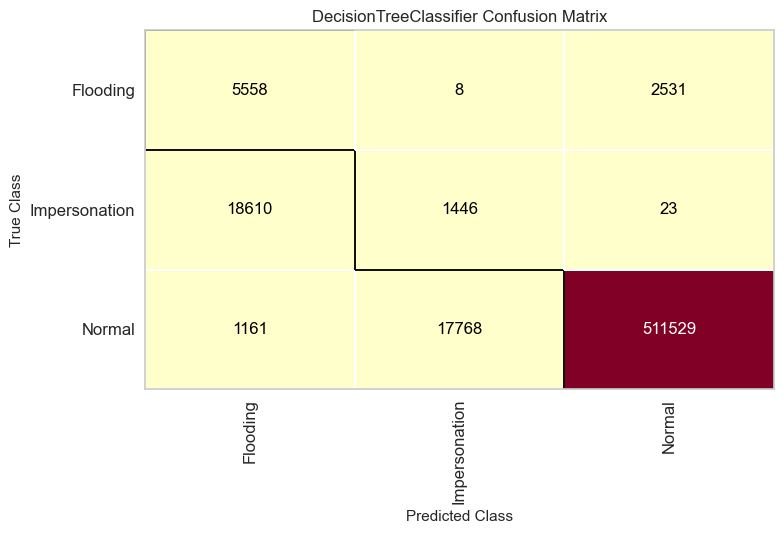

In [24]:
X_train, y_train = X_awid2trn_encoded, y_awid2trn
X_test, y_test = X_awid2tst_encoded, y_awid2tst

y_train = y_train['class'].astype('category').cat.codes
y_test = y_test['class'].astype('category').cat.codes

# Belirli parametrelerle dt modeli
dt_model = DecisionTreeClassifier(
    max_depth=20,
    ccp_alpha=0.001,
    max_leaf_nodes=100,
    min_samples_leaf=2,
    random_state=42
)


dt_model.fit(X_train, y_train)

evaluate_classifier(dt_model, X_test, y_test)

### LightGBM

Accuracy: 0.9293
Weighted Precision: 0.9246
Micro Precision: 0.9293
Macro Precision: 0.5908
Weighted Recall: 0.9293
Micro Recall: 0.9293
Macro Recall: 0.5552
Weighted F1 Score: 0.9269
Micro F1 Score: 0.9293
Macro F1 Score: 0.5716
AUC Score: 0.8963


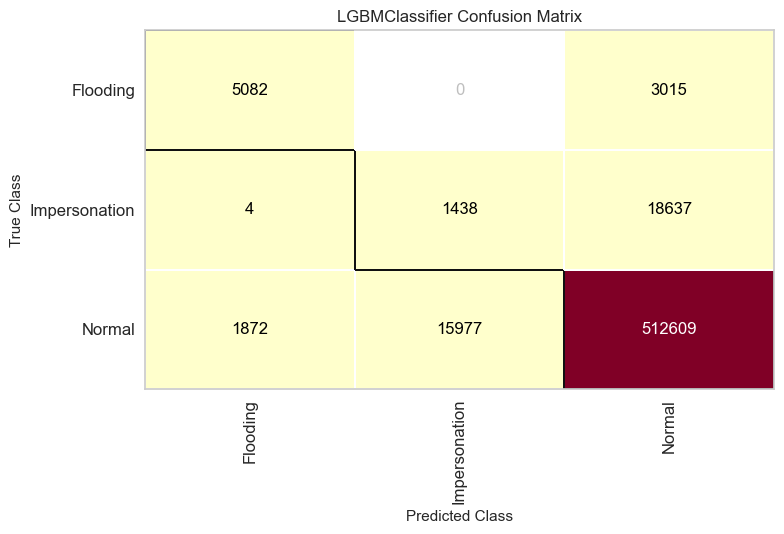

In [25]:
X_train, y_train = X_awid2trn_encoded, y_awid2trn
X_test, y_test = X_awid2tst_encoded, y_awid2tst

y_train = y_train['class'].astype('category').cat.codes
y_test = y_test['class'].astype('category').cat.codes

lgb_params = {
    'objective': 'multiclass',
    'num_class': y_train.nunique(),
    'metric': 'multi_logloss',
    'boosting_type': 'gbdt',
    'num_leaves': 20,
    'learning_rate': 0.01,
    'max_bin': 20,
    'max_depth': 10,
    'min_child_samples': 30,
    'min_data_in_bin': 10,
    'min_split_gain': 0.1,
    'n_estimators': 80,
    'reg_alpha': 0.01,
    'reg_lambda': 0.01,
    'n_jobs': 1,
    'verbose': 0
}

lgb_model = LGBMClassifier(**lgb_params)
lgb_model.fit(X_train, y_train)

evaluate_classifier(lgb_model, X_test, y_test)

### Logistic Regression

Accuracy: 0.9101
Weighted Precision: 0.9675
Micro Precision: 0.9101
Macro Precision: 0.7098
Weighted Recall: 0.9101
Micro Recall: 0.9101
Macro Recall: 0.8422
Weighted F1 Score: 0.9301
Micro F1 Score: 0.9101
Macro F1 Score: 0.7075
AUC Score: 0.9779


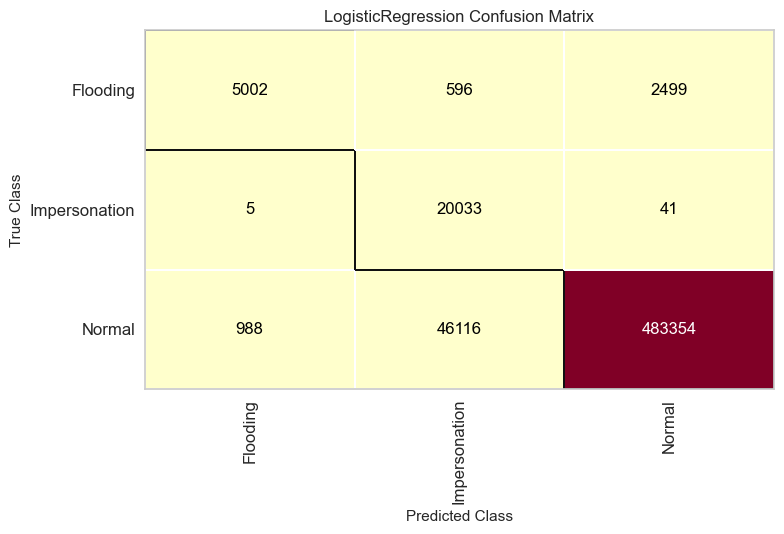

In [26]:
X_train, y_train = X_awid2trn_encoded, y_awid2trn
X_test, y_test = X_awid2tst_encoded, y_awid2tst

y_train = y_train['class'].astype('category').cat.codes
y_test = y_test['class'].astype('category').cat.codes

# Belirli parametreler ile logistic reg modeli
lr_model = LogisticRegression(
    solver='sag',
    max_iter=1000,
    tol=0.01,
    random_state=42,
    multi_class='multinomial'
)

lr_model.fit(X_train, y_train)

evaluate_classifier(lr_model, X_test, y_test)

### SGDClassifier

Accuracy: 0.8882
Weighted Precision: 0.9242
Micro Precision: 0.8882
Macro Precision: 0.6227
Weighted Recall: 0.8882
Micro Recall: 0.8882
Macro Recall: 0.5372
Weighted F1 Score: 0.9053
Micro F1 Score: 0.8882
Macro F1 Score: 0.5702
AUC Score: 0.6275


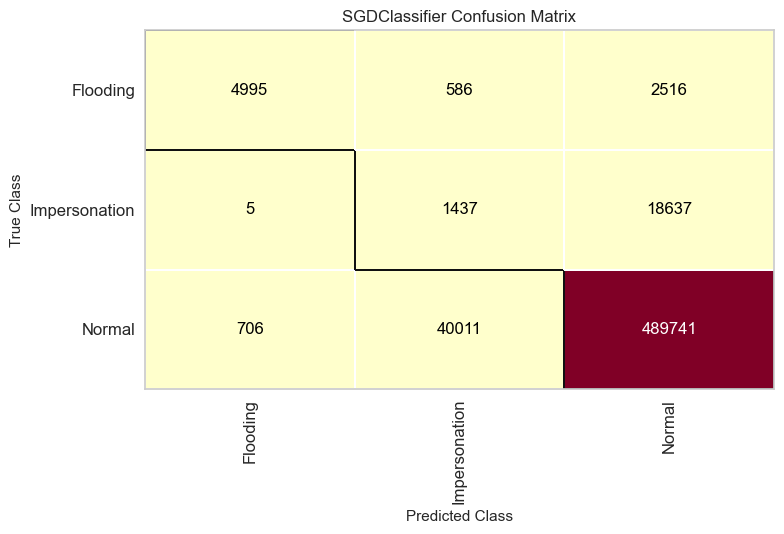

In [27]:
X_train, y_train = X_awid2trn_encoded, y_awid2trn
X_test, y_test = X_awid2tst_encoded, y_awid2tst

y_train = y_train['class'].astype('category').cat.codes
y_test = y_test['class'].astype('category').cat.codes

# Belirli parametreler ile SGD Classifier
sgd_model = SGDClassifier(
    tol=1e-05,
    loss='modified_huber',
    early_stopping=True,
    random_state=42
)

sgd_model.fit(X_train, y_train)

evaluate_classifier(sgd_model, X_test, y_test)

### LinearSVC

Accuracy: 0.9181
Weighted Precision: 0.9637
Micro Precision: 0.9181
Macro Precision: 0.5942
Weighted Recall: 0.9181
Micro Recall: 0.9181
Macro Recall: 0.8452
Weighted F1 Score: 0.9337
Micro F1 Score: 0.9181
Macro F1 Score: 0.6626
AUC Score: 0.9768


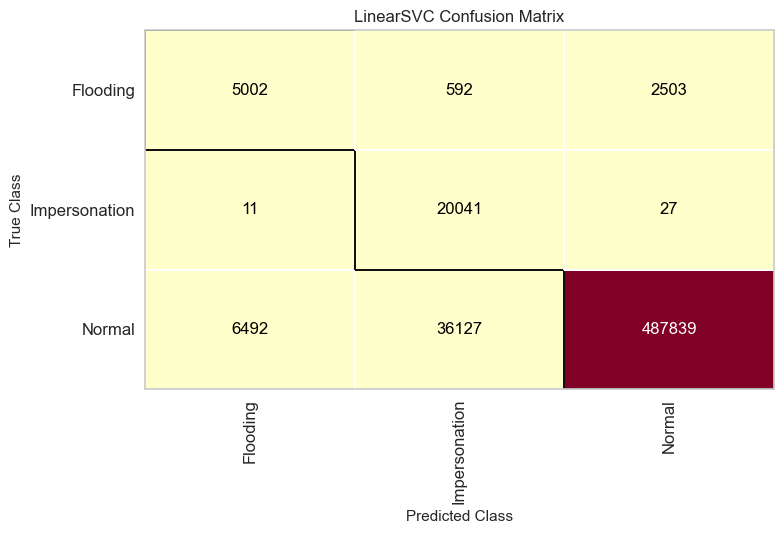

In [28]:
X_train, y_train = X_awid2trn_encoded, y_awid2trn
X_test, y_test = X_awid2tst_encoded, y_awid2tst

y_train = y_train['class'].astype('category').cat.codes
y_test = y_test['class'].astype('category').cat.codes

# Belirli parametreler ile LinearSVC
linear_svc_model = LinearSVC(
    max_iter=20000,
    C=1.5,
    random_state=42
)

linear_svc_model.fit(X_train, y_train)

evaluate_classifier(linear_svc_model, X_test, y_test)

### Random Forest

Accuracy: 0.9633
Weighted Precision: 0.9771
Micro Precision: 0.9633
Macro Precision: 0.7973
Weighted Recall: 0.9633
Micro Recall: 0.9633
Macro Recall: 0.8978
Weighted F1 Score: 0.9675
Micro F1 Score: 0.9633
Macro F1 Score: 0.8232
AUC Score: 0.9707


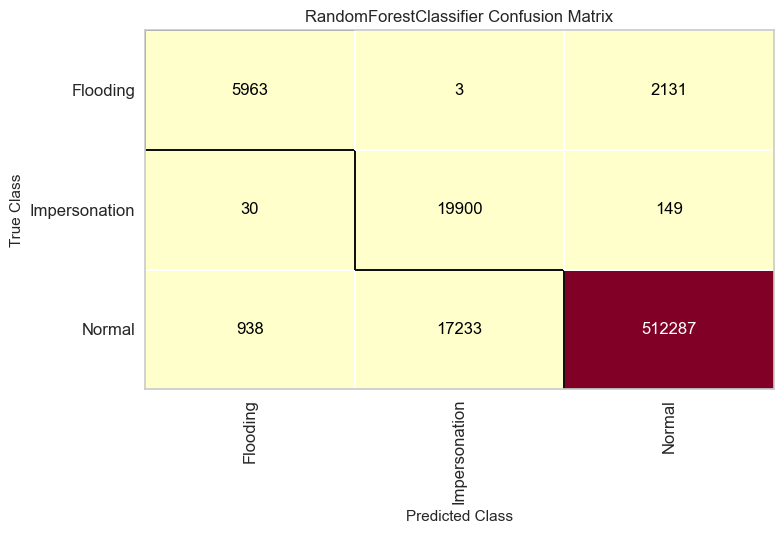

In [29]:
X_train, y_train = X_awid2trn_encoded, y_awid2trn
X_test, y_test = X_awid2tst_encoded, y_awid2tst

y_train = y_train['class'].astype('category').cat.codes
y_test = y_test['class'].astype('category').cat.codes

# Belirli parametreler ile Random Forest
random_forest_model = RandomForestClassifier(
    max_depth=20,
    ccp_alpha=0.001,
    max_leaf_nodes=100,
    min_samples_leaf=2,
    random_state=42
)

random_forest_model.fit(X_train, y_train)

evaluate_classifier(random_forest_model, X_test, y_test)

### Extra Trees

Accuracy: 0.9316
Weighted Precision: 0.9283
Micro Precision: 0.9316
Macro Precision: 0.6544
Weighted Recall: 0.9316
Micro Recall: 0.9316
Macro Recall: 0.5538
Weighted F1 Score: 0.9295
Micro F1 Score: 0.9316
Macro F1 Score: 0.5942
AUC Score: 0.9416


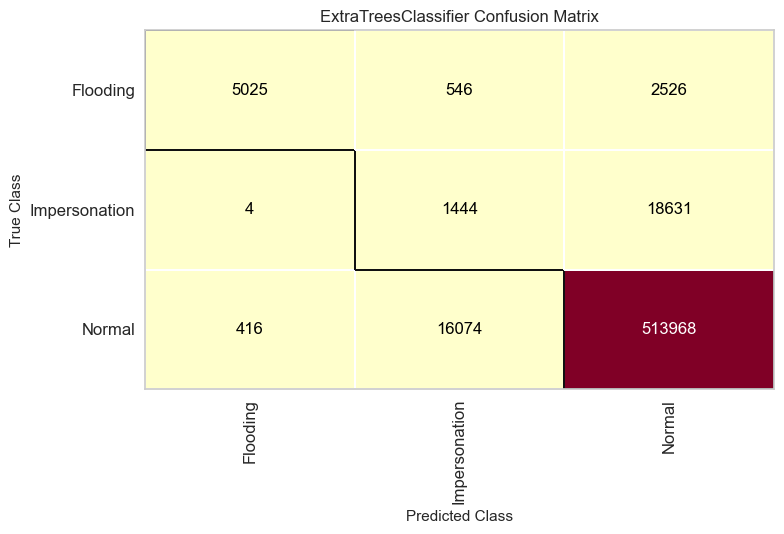

In [30]:
X_train, y_train = X_awid2trn_encoded, y_awid2trn
X_test, y_test = X_awid2tst_encoded, y_awid2tst

y_train = y_train['class'].astype('category').cat.codes
y_test = y_test['class'].astype('category').cat.codes

# Belirli hiperparametreler ile ET model
et_model = ExtraTreesClassifier(
    max_depth=200,
    n_estimators=200,
    ccp_alpha=0.0001,
    max_leaf_nodes=500,
    min_samples_leaf=2,
    min_samples_split=10,
    random_state=42
)

et_model.fit(X_train, y_train)

evaluate_classifier(et_model, X_test, y_test)